### About Notebook:
#### This notebook describes the apporaches to detect anomaly detection in univariate time series

In [143]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import boxcox
import warnings
warnings.filterwarnings('ignore')

In [144]:
def read_data(paths):
    df = pd.read_csv(paths)
    df.replace(np.nan,0,inplace=True)
    df.drop(columns={'Page'},inplace=True)
    df = df.transpose()
    df['sum'] = df.sum(axis=1)
    df.reset_index(inplace=True)
    df = df[['index','sum']]
    df.rename(columns={'index':'Date','sum':'value'},inplace=True)
    df.Date = pd.to_datetime(df.Date)
    return df

In [145]:
dataframe = read_data("./Datasets/train_2.csv")

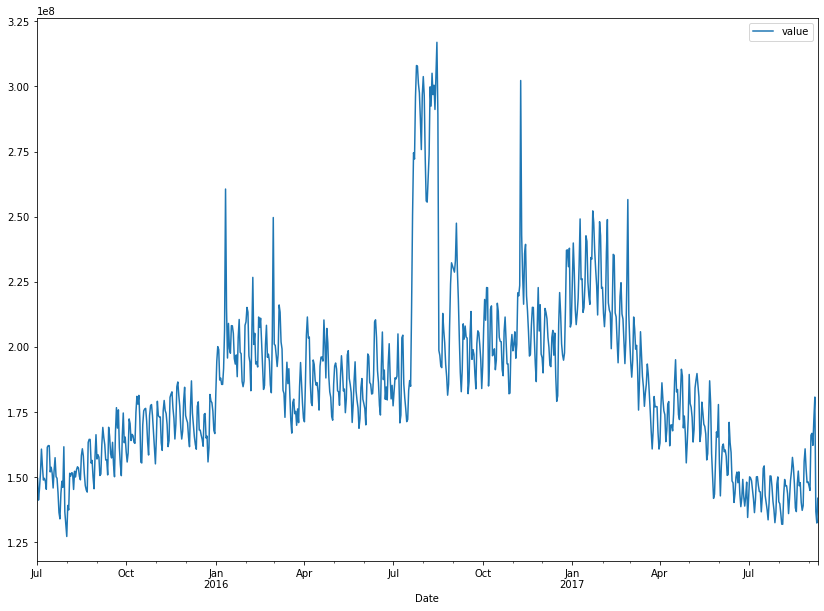

In [146]:
dataframe.plot(x='Date',y='value',figsize=(14,10))

### Types Of Anaomaly

### Anomaly detection with  z-Score

(array([ 66., 153., 199., 191., 113.,  41.,  14.,   7.,   9.,  10.]),
 array([1.27190355e+08, 1.46165819e+08, 1.65141283e+08, 1.84116747e+08,
        2.03092211e+08, 2.22067674e+08, 2.41043138e+08, 2.60018602e+08,
        2.78994066e+08, 2.97969530e+08, 3.16944994e+08]),
 <a list of 10 Patch objects>)

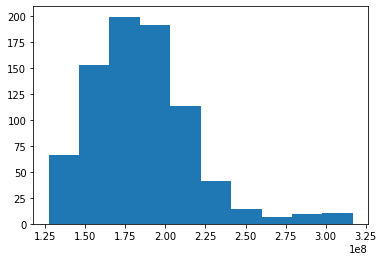

In [147]:
plt.hist(dataframe.value)

In [148]:
def z_score(df,boundary):
    mean_value = np.mean(df.value)
    stddev_value = np.std(df.value)
    z_score = [(i - mean_value) / stddev_value for i in df.value]
    df['z_score_anomaly'] = 0
    df.set_value(np.where(np.abs(z_score) > boundary)[0],'z_score_anomaly',-1)
    return df

In [149]:
def plot_anomaly(dataframe,anomaly_col):
    anomaly = dataframe.loc[dataframe[anomaly_col]==-1,['Date','value']]
    fig,ax= plt.subplots(figsize=(14,8))
    ax.plot(dataframe.Date,dataframe.value,color='green',label='Value')
    ax.scatter(anomaly.Date,anomaly.value,color='red',label='Anomaly')
    plt.legend()
    plt.show()
    

#### Plot Anomalies based on z-Score

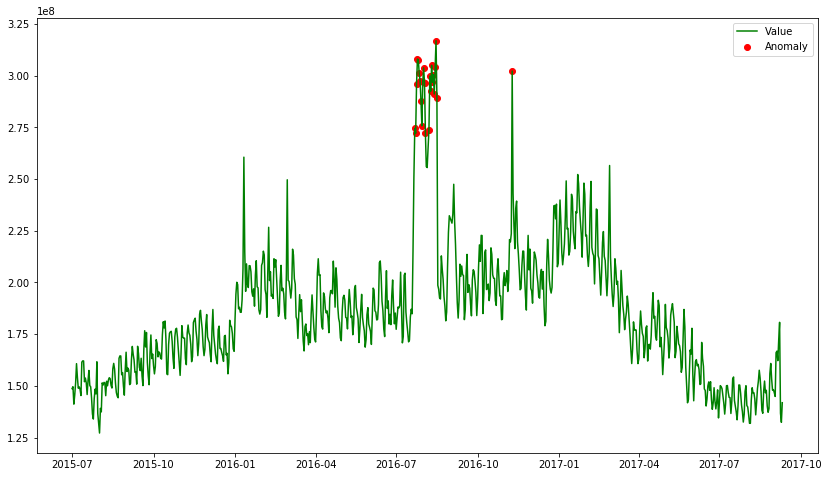

In [150]:
plot_anomaly(z_score(dataframe,2.5),'z_score_anomaly')

### Robust z-Score Method

In [151]:
def outliers_modified_z_score(dataframe,boundary):
    med_value = np.median(dataframe.value)
    mad_value = np.median([np.abs(i - med_value) for i in dataframe.value])
    mod_z_scores = [0.6745 * (i - med_value) / mad_value for i in dataframe.value]
    dataframe['modified_z_scores'] = 0
    dataframe.set_value(np.where(np.abs(mod_z_scores) > boundary)[0],'modified_z_scores',-1)
    return dataframe

#### Plot Anomalies based on robust z-Score

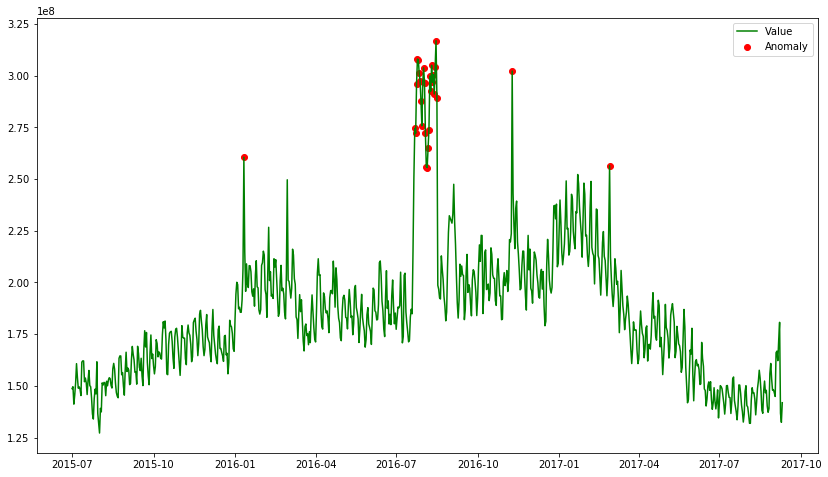

In [152]:
plot_anomaly(outliers_modified_z_score(dataframe,2.5),'modified_z_scores')

### Anomaly Detection with IQR

In [153]:
def outliers_iqr(dataframe):
    q1, q3 = np.quantile(dataframe.value, [.25, .75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    dataframe['iqr'] = 0
    dataframe.set_value(np.where((dataframe.value > upper_bound) | (dataframe.value < lower_bound))[0],'iqr',-1)
    return dataframe

#### Plot IQR

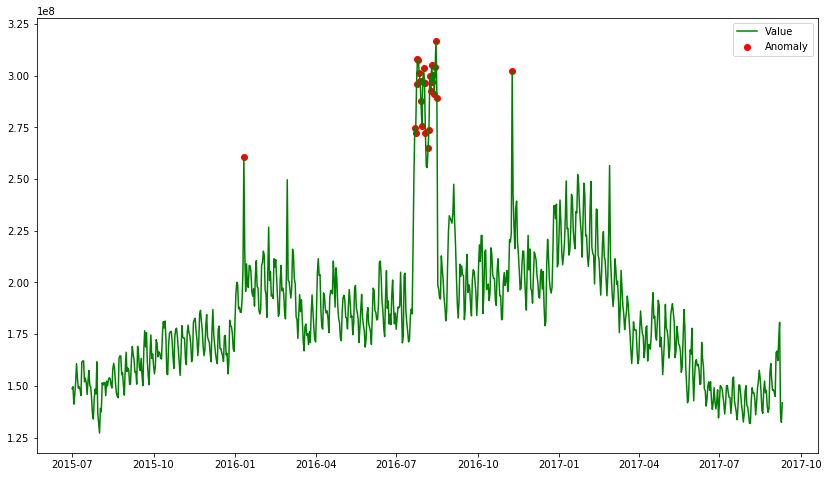

In [154]:
plot_anomaly(outliers_iqr(dataframe),'iqr')

### Anomaly Detection Based on IsolationForest

In [155]:
scaler = StandardScaler()
np_scaled = scaler.fit_transform(dataframe[['value']])
data = pd.DataFrame(np_scaled)
model =  IsolationForest(contamination=0.04)
model.fit(data) 
dataframe['IsolationForestAnomaly'] = pd.Series(model.predict(data))

#### Plot IsolationForest

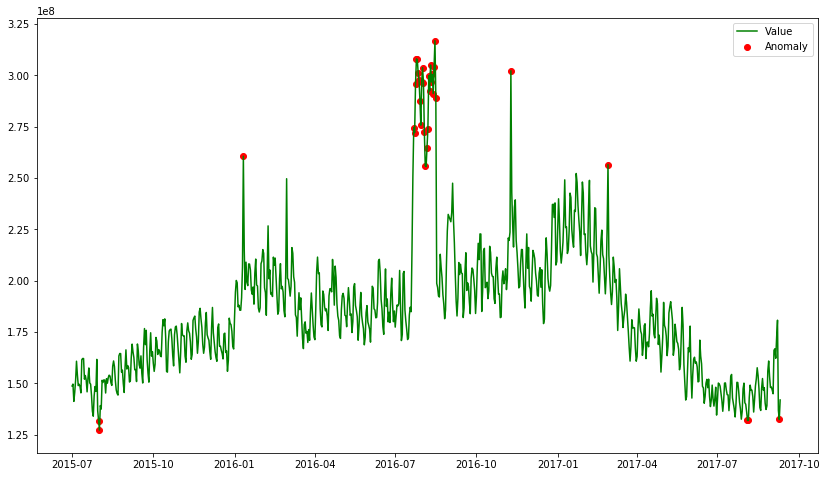

In [156]:
plot_anomaly(z_score_df,'IsolationForestAnomaly')

### Anomaly Detection Using Support Vector Machines

In [157]:
scaler = StandardScaler()
np_scaled = scaler.fit_transform(dataframe[['value']])
data = pd.DataFrame(np_scaled)
model = OneClassSVM(nu=0.02, kernel="rbf", gamma=0.04)
model.fit(data)
dataframe['Anomaly_SVM'] = pd.Series(model.predict(data))

#### Plot SVM

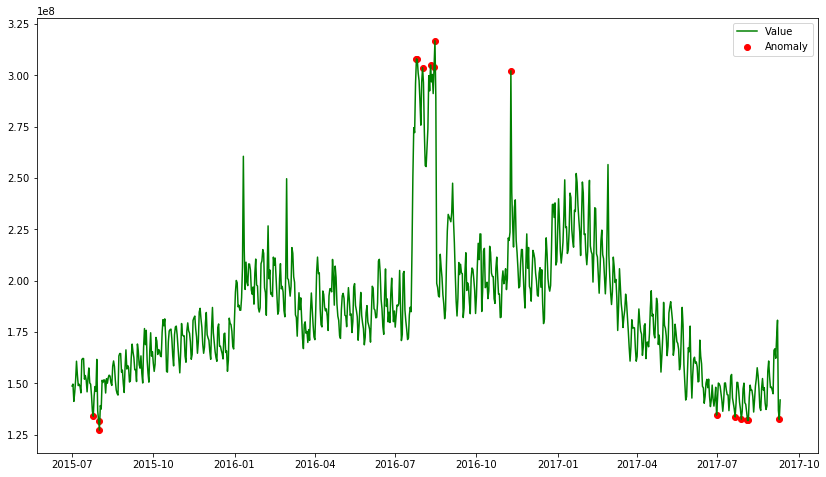

In [158]:
plot_anomaly(dataframe,'Anomaly_SVM')

#### Details

##### z-Score Based

##### Robust z-Score Based

#### Isolation Forest

#### Conclusions and Next Steps